In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq

# Read the file, trim out the silent part, plot it

### Read & plot the file, detect the "silent" part & cut it out:

In [419]:
def soundclip(file, S=4000,w=1000,length=0.2,plotraw=True,plottrim=True):  
    
    (r,audio_st) = wav.read(file)
    audio1 = audio_st[:,0]                                    # convert to mono
    if plotraw==True:                                          # plot the audio waves over a time interval
        f1 = plt.figure()
        ax1 = f1.add_subplot(211)
        plt.title('Audio file')
        plt.ylabel('Amplitudes')
        plt.plot(audio1, color='m')                           
        
    t = 0                                                      
    Y = 0
    while t<(len(audio1)-w):                                   # S = volume cutoff for splicing out "silence"
        interval = abs(audio1[t:t+w])                          # w = width for test intervals
        if np.average(interval) <= S:                          # length = the length of the sound that will be kept
            t = t+w
        else:
            break
    audio = audio1[t+w:t+w+int(length*r)]                   
    file = (r,audio)
    if plottrim==True:
        f2 = plt.figure()
        ax2 = f2.add_subplot(212)
        plt.title('Audio - trimmed')
        plt.ylabel('Amplitudes')
        plt.plot(audio, color='m')
    
    plt.show()

    return(file)

In [421]:
#print(soundclip('C major.wav', length=0.3))

In [425]:
#print(soundclip('Ef dom7.wav', S=2000, length=0.2))

# Fourier transform

In [111]:
import pylab

In [247]:
def fftaudio(file,plotfft=True):                       # input = the output of soundclip
    (r,audio_m) = file
    audioft = fft(audio_m)                             # transform
    audioreal = abs(audioft)                           # conjugate of the complex values for plotting (amplitudes)
    audiopos = audioreal[0:int((len(audioreal)+1)/2)]  # cut out the negatives (just the opposite of the positive values so unnecessary)
    audiopos_adjust = audiopos/np.max(audiopos)        # scale the y axis to be from 0 to 1
    freq = fftfreq(len(audioreal), 1/r)                # get frequencies
                                                            # window length = length of the audio file (after trimmed)
                                                            # sample spacing = 1/rate
    freqpos = freq[0:int((len(freq)+1)/2)]             # just take the positive ones
    
    if plotfft==True:
        plt.xlabel('frequencies [Hz]')
        plt.xscale('log')
        pylab.xlim(20, 4200)                           # 20, 4200 = range of piano frequencies
        plt.plot(freqpos, audiopos_adjust, color='g')
    
    return(freqpos, audiopos_adjust)            

In [428]:
#fftaudio((soundclip('C major.wav', S=4000,w=1000,length=0.5,plotraw=True,plottrim=True)), plotfft=True)
#fftaudio((soundclip('Ef dom7.wav', S=2000,w=1000,length=0.3,plotraw=True,plottrim=True)), plotfft=True)

# Process out the main frequencies

In [261]:
def cleanup(fftaudio, lim=0.6): # limit is the minimum power needed (after scaling the powers to 1) to accept the frequency
    freq = fftaudio[0]
    powers1 = fftaudio[1]
    powers = powers1/max(powers1)
    frequencies1=[]
    for i in range(0,len(freq)):                                   # take all frequencies with power above the limit
        if powers[i] > lim:
            frequencies1.append(freq[i])
    
    frequencies=[frequencies1[0]]
    for j in range(1,len(frequencies1)):                           # there may be multiple frequencies for the same note (ex. 260, 263)
        if frequencies1[j]-frequencies[len(frequencies)-1] > 5:    # so this removes potential "repeats"
            frequencies.append(frequencies1[j])

    return(frequencies)

In [430]:
# cleanup(fftaudio((soundclip('C major.wav', S=4000,w=1000,length=0.5,plotraw=True,plottrim=True)), plotfft=True), lim=0.6)
# cleanup(fftaudio((soundclip('Ef dom7.wav', S=2000,w=1000,length=0.3,plotraw=True,plottrim=True)), plotfft=True), lim=0.6)

# Return the frequencies as notes (i.e. 440 --> A)

### Some sets that will get used a bunch:
* Notes = each note in octave 4, listed by its name, frequency, and numerical position in the scale
* letters, fs, and nums are just each such component of Notes

In [197]:
Notes = [["C",261.63,1],["C#",277.18,2],["D",293.66,3],["Eb",311.13,4],["E",329.63,5],["F",349.23,6],["F#",369.99,7],["G",392,8],["Ab",415.3,9],["A",440,10],["Bb",466.16,11],["B",493.88,0]]
letters = [i[0] for i in Notes]
fs = [float(i[1]) for i in Notes]
nums = [i[2] for i in Notes]

### Set all frequencies to be in octave 4, then match them to their correctly-tuned frequency

In [198]:
fs_edge = [254.28]
for i in fs:
    fs_edge.append(i)
fs_edge.append(509)

def autotune(frequencies):
    octave4 = []
    for f in frequencies:
        if f < 254.28365:
            while f < 254.28365:
                f = 2*f
        if f >= 508.5672:
            while f > 508.5672:
                f = 0.5*f
        if 254.28365 <= f < 508.5672:
            octave4.append(f)
    
    autotune_notes = []
    for f in octave4:
        for j in range(1,13):
            if (f > (np.average([fs_edge[j],fs_edge[j-1]]))) and (f < (np.average([fs_edge[j],fs_edge[j+1]]))):
                autotune_notes.append(Notes[j-1])
    return(autotune_notes)

In [199]:
test = np.array([27.5, 1046.502, 391.9954]) # A, C, & G that are slightly off, different octaves
auto_test = autotune(test)
print(auto_test)

[['A', 440, 10], ['C', 261.63, 1], ['G', 392, 8]]


In [378]:
CMfrequencies = cleanup(fftaudio((soundclip('C major.wav', S=4000,w=1000,length=0.5,plotraw=False,plottrim=False)), plotfft=False), lim=0.6)
autotune(CMfrequencies)

[['C', 261.63, 1], ['E', 329.63, 5], ['G', 392, 8]]

In [431]:
Effrequencies = cleanup(fftaudio((soundclip('Ef dom7.wav', S=2000,w=1000,length=0.3,plotraw=False,plottrim=False)), plotfft=False), lim=0.6)
autotune(Effrequencies)

[['G', 392, 8], ['Bb', 466.16, 11], ['C#', 277.18, 2], ['Eb', 311.13, 4]]

# Determine what the chord is & print out its name + notes

#### Using the 9 common chord types:

* Major triad (0,4,7)
* Minor triad (0,3,7)
* Diminished (0,3,6)
* Major seventh (0,4,7,11)
* Minor Seventh (0,3,7,10)
* Dominant Seventh (0,4,7,10)
* Sus2 (0,2,7)
* Sus4 (0,5,7)
* Augmented (0,4,8)
* No extended / inversions given everything is being squished into one octave)

#### A couple test chords

In [434]:
A_minor7 = autotune((261.63, 329.63, 392, 440))
#print(A_minor7)

G_sus4 = autotune((390,261.63,294))
#print(G_sus4)

CMfrequencies = cleanup(fftaudio((soundclip('C major.wav', S=4000,w=1000,length=0.5,plotraw=False,plottrim=False)), plotfft=False), lim=0.6)
C_M = autotune(CMfrequencies)
#print(C_M)

Effrequencies = cleanup(fftaudio((soundclip('Ef dom7.wav', S=2000,w=1000,length=0.3,plotraw=False,plottrim=False)), plotfft=False), lim=0.6)
Ef_dom7 = autotune(Effrequencies)
#print(Ef_dom7)

### Take the main frequencies as found in the autotune function, print the name/type of chord it makes
* Ignoring inversion (having put everything into octave 4)

In [385]:
def notes_chord(autotune_notes):           # takes the collection of notes and matches it to the chord it is
    nums = [i[2] for i in autotune_notes]
    for i in nums:                         # there's only chord the notes are making, but don't know which one would be the root after "squishing" them so have to try each configuration
        chord_i = [(j-i)%12 for j in nums]       # mod 12
        chord_i.sort()                           # put in numerical order --> this gives the spaces between each note with reference to the first one
        chord_nums = [(j+i)%12 for j in chord_i] # adding i back, mod 12, gives the OG notes but in the right order
        chord_letters = [letters[i-1][0] for i in chord_nums]
        
        if len(chord_i) == 3:
            chord_i = np.append(chord_i,0)
        if chord_i[1]==2 and chord_i[2]==7 and chord_i[3]==0:
            print("{} sus2" .format(letters[chord_nums[0]-1]))
            return(chord_nums,chord_letters, "sus2")
        if chord_i[1] == 3:
            if chord_i[2] == 7 and chord_i[3] == 0:
                print("{} minor" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "minor")
            if chord_i[2] == 6 and chord_i[3] == 0:
                print("{} diminished" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "diminished")
            if chord_i[2] == 7 and chord_i[3] == 10:
                print("{} minor seventh" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "minor seventh")
        if chord_i[1] == 4:
            if chord_i[2] == 7 and chord_i[3] == 0:
                print("{} major" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "major")
            if chord_i[2] == 7 and chord_i[3] == 11:
                print("{} major seventh" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "major seventh")
            if chord_i[2] == 7 and chord_i[3] == 10:
                print("{} dominant seventh" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "dominant seventh")
            if chord_i[2] == 8 and chord_i[3] == 0:
                print("{} augmented" .format(letters[chord_nums[0]-1]))
                return(chord_nums,chord_letters, "augmented")
        if chord_i[1]==5 and chord_i[2]==7 and chord_i[3]==0:
            print("{} sus4" .format(letters[chord_nums[0]-1]))
            return(chord_nums,chord_letters, "sus4")

In [436]:
# testing it out:
print(notes_chord(A_minor7)[1:3])
print(notes_chord(G_sus4)[1:3])
print(notes_chord(Ef_dom7)[1:3])
print(notes_chord(C_M)[1:3])

A minor seventh
(['A', 'C', 'E', 'G'], 'minor seventh')
G sus4
(['G', 'C', 'D'], 'sus4')
Eb dominant seventh
(['E', 'G', 'B', 'C'], 'dominant seventh')
C major
(['C', 'E', 'G'], 'major')


# Picking the keys that fit

“elimination round” sort of function that checks which keys have the first note, and then of those remaining, checks which have the second, etc.
* just using major & natural minor keys

In [437]:
def findmykeys(notes_chord):
    keys=[]
    tonics = np.arange(1,13) # set integers 1 to 12 to represent the major key tonics
    for i in notes_chord[0]: 
        for j in tonics:
            key_j = [(j+n-1)%12 for n in Cn_an] # check which keys contain i (j=1 --> C, j=12 --> B)
            if i not in key_j: # if the key doesn't contains i it gets set to 0
                tonics[j-1]=0
    for j in tonics:
        l = letters[j-1]
        m = letters[((j+9)%12 - 1)]
        if j > 0:
            keys.append(("{} major" .format(l),j,1))
            keys.append(("{} minor" .format(m),(j+9)%12,0))
            print("{} major = {} minor" .format(l,m))
    return(keys)

In [392]:
#testing it out with known chords

findmykeys(notes_chord(G_sus4)) # should get CM=Am (1,10), GM=Em (8,5), FM=Dm (6,3), BfM=Gm (11,8), EfM=Cm (4,1)

G sus4
C major = A minor
Eb major = C minor
F major = D minor
G major = E minor
Bb major = G minor


[('C major', 1, 1),
 ('A minor', 10, 0),
 ('Eb major', 4, 1),
 ('C minor', 1, 0),
 ('F major', 6, 1),
 ('D minor', 3, 0),
 ('G major', 8, 1),
 ('E minor', 5, 0),
 ('Bb major', 11, 1),
 ('G minor', 8, 0)]

In [376]:
findmykeys(notes_chord(A_minor7)) # should get CM=Am, FM=Dm, GM=Em

C major = A minor
F major = D minor
G major = E minor


[('C major', 1, 1),
 ('A minor', 10, 0),
 ('F major', 6, 1),
 ('D minor', 3, 0),
 ('G major', 8, 1),
 ('E minor', 5, 0)]

# For each key, determine where in the key that chord fits

* a chord relative to a key just becomes a matter of numerical difference.
* For example, if the key is C major and the chord is G major, the key's tonic is C=1. The notes are G=8, B=12 and D=3. So the chord, relative to C major, is defined as the notes that have a "difference" of 7, 11, and 2 half-steps from the tonic, in other words the V chord (though I'm realizing this means if the key has something like B=12 as its tonic, then C=1 would be a difference of 1, so mod12 is going to come into play here).


In [346]:
def lockinkey(keys,notes_chord): # for each key, determine where the chord "locks" in #yaypuns
    notes = notes_chord[0]
    name = notes_chord[2]
    for key in keys:
        incontext = []
        for note in notes:
            incontext.append((note - key[1])%12)
        if incontext[0]==0:
            print (key[0],'1', name)
        if incontext[0]==2:
            print(key[0],'2', name)
        if (key[2]==1 and incontext[0]==4) or (key[2]==0 and incontext[0]==3):
            print(key[0],'3', name)
        if incontext[0]==5:
            print(key[0],'4', name)
        if incontext[0]==7:
            print(key[0],'5', name)
        if incontext[0]==9:
            print(key[0],'6', name)
        if (key[2]==1 and incontext[0]==11) or (key[2]==0 and incontext[0]==10):
            print(key[0],'7', name)

In [415]:
# testing it out with a known chord
lockinkey(findmykeys(notes_chord(G_sus4)), notes_chord(G_sus4))

G sus4
C major = A minor
Eb major = C minor
F major = D minor
G major = E minor
Bb major = G minor
G sus4
C major 5 sus4
A minor 7 sus4
Eb major 3 sus4
C minor 5 sus4
F major 2 sus4
D minor 4 sus4
G major 1 sus4
E minor 3 sus4
Bb major 6 sus4
G minor 1 sus4


# Bringing it all together in one function

#### And now all the functions are in place to be combined! This function does the following:

##### Line 1: "frequencies"
* takes in an audio file, converts it to mono, & plots this audio data
* cuts out the "silence" (aka noise in the environment before the chord) & trims the audio to a user-inputted length
* through fourier transforms and scaling the powers to (0,1), pinpoints the frequencies above a certain threshold
* cuts out any repeated frequencies (aka frequencies that are slightly different but represent the same note)

##### Line 2: "frequencies_4"
* puts all frequencies into the same octave so that any combination of the same objective notes will return the same chord (simplifies for octaves & undoes any inversion to get at the "original" baseline chord
* tunes each frequency to its nearest exact frequency 
* Example: 884 Hz will be brought down an octave to 442, and then tuned to A4 = 440 Hz as it's the closest note

##### Line 3: "chordtype"
* identifies the chord by its name, root, & integer notation

##### Line 4: "keystouse"
* determines which standard major/minor keys contain all the notes in this chord
* determines the exact way this chord "fits" into each such scale 
* Example: "A minor 3 major" means "in the A minor key, this chord will function as the major triad built up from the 3rd note in the scale" whereas "C major 1 major" is saying "in C major, this chord is the standard major triad built up from the root"

In [393]:
def runitall(file,S=4000,w=1000,length=0.5,plotraw=True,plottrim=True,plotfft=True,lim=0.6):
    frequencies = cleanup(fftaudio((soundclip(file,S,w,length,plotraw,plottrim)), plotfft), lim)
    frequencies_4 = autotune(frequencies)
    chordtype = notes_chord(frequencies_4)
    keystouse = findmykeys(chordtype)
    chordinkey = lockinkey(keystouse,chordtype)

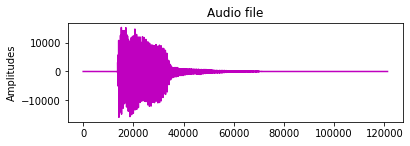

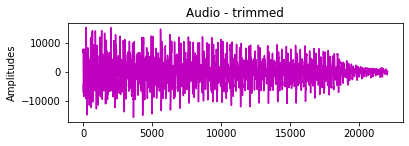

C major
C major = A minor
F major = D minor
G major = E minor
C major 1 major
A minor 3 major
F major 5 major
D minor 7 major
G major 4 major


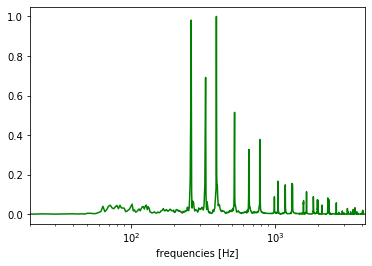

In [394]:
runitall('C major.wav') # input = C, E, and G all in octave 4 on the piano

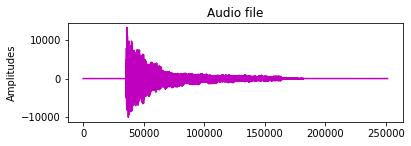

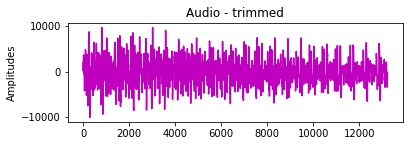

Eb dominant seventh
Ab major = F minor
Ab major 5 dominant seventh
F minor 7 dominant seventh


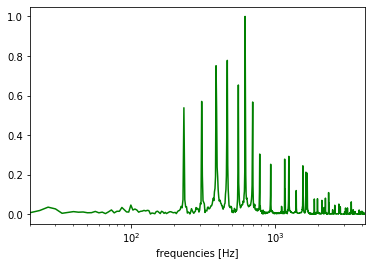

In [439]:
runitall('Ef dom7.wav', S=2000,w=1000,length=0.3,plotraw=True,plottrim=True,plotfft=True,lim=0.6)
# input = Ef, G, Bf, Cs in 3 different octaves: Bf-3, Ef-4, G-4, Cs-5
# so it should get converted to Cs-4, Ef-4, G-4, B-4 which inverts weirdly to put it all in octave 4
# then get identified as Ef augmented despite the order being flipped
# then get placed into A flat major (on the 5) / F minor (on the 7)

# Hear that chord fit into a chosen key:

* Once the function spits out what chords were inputted & all the different ways it can function in different keys, the following function is a way to hear the outcome, inputting the results just given to hear playback of the standard root major/minor chord for the key, followed by the (autotuned, un-inverted) chord, back to the root

In [464]:
import math
import pyaudio

In [ ]:
scale_notes = {
    'C': 261.63, 
    'C#': 277.18,
    'D': 293.66,
    'D#': 311.13,
    'E': 329.63,
    'F': 349.23,
    'F#': 369.99,
    'G': 329.00,
    'G#': 415.30,
    'A': 440.00,
    'A#': 466.16,
    'B': 493.88
}

note_names = 'cCdDefFgGaAb'

def playnote(root, chord):
    if chord == "minor":
        intervals = [0,3,7]
    if chord_style == "major":
        intervals = [0,4,7]
    if chord == "minor seventh":
        intervals = [0,3,7,10]
    if chord == "major seventh":
        intervals = [0,4,7,11]
    if chord == "augmented":
        intervals = [0,4,8]
    if chord == "diminished":
        intervals = [0,3,6]
    if chord == "dominant seventh":
        intervals = [0,7,10]
    if chord == "sus2":
        intervals = [0,2,7]
    if chord == "sus4":
        intervals = [0,5,7]

    num_notes = len(chord)

    p = pyaudio.PyAudio()  # initialize audio
    samplerate = 20000
    length = 1  # seconds
    frames = int(samplerate*length)

    wavedata = ''

    # generating waves
    stream = p.open(
        format=p.get_format_from_width(1),
        channels=1,
        rate=sample_rate,
        output=True)

    CHUNK = 256

    octave = int(note[1])
    frequencies = []
    for tone in chord_tones:
        chord_note = note_names.index(note[0]) + tone
        if chord_note<12:
            chord_note = note_names[chord_note]
            frequencies.append(scale_notes[chord_note] * (2**(octave + 1)))
            print(frequencies)
        else:
            chord_note = note_names[chord_note-12]
            frequencies.append( scale_notes[chord_note] * (2**(octave + 2)))
            print(frequencies)

    y=0
    for x in range(frames//CHUNK):
        n=0
        wavedata=b''
        while n<CHUNK:
            wave=0
            for freqs in frequencies:
                wave += math.sin((y) / ((sample_rate / freqs) / math.pi)) * 127 + 128
            wave = wave/num_notes
            wavedata += bytes([int(wave)])
            y+=1
            n+=1

        stream.write(wavedata)

    stream.stop_stream()
    stream.close()
    p.terminate()


song = []
while True:
    song_composing = True
    note = ''
    while note != 'p':
        note = str(input(
            'Enter note (a-G) (capital for sharp) and an octave (0-8) or any other key to play: '))
        if note[0] in scale_notes:
            chord_style = str(
                input('Enter chord quality (maj, min, five): '))
            song.append((note, chord_style))
            playnote(note, chord_style)

    for chord in song:
        playnote(chord[0], chord[1])
    break